Every year, Detroit issues millions of dollars in fines to residents that fail to maintain their property (called blight violations), and every year, many of these fines remain unpaid. This project uses machine learning to try to predict whether or not a resident will comply and pay the fines of the ticket.

Four CSV files are used in this notebook:

- train.csv: this contains information about each blight ticket that is issued. Columns used:
    - ticket_id: unique identifier for the ticket
    - agency_name - agency that issued the ticket
    - ticket_issued_date - date and time ticket was issued
    - violation_code - type of violation
    - disposition - judgement and judgement type
    - fine_amount - violation fine amount, excluding fees
    - discount_amount - discount applied, if any
    - compliance (target variable for prediction - 1 if compliant, 0 otherwise
    
- addresses.csv: this contains the address of each ticket ID

- latlons.csv: this contains the longitude and latitude of each address 

- Parcel_Points_Ownership.csv: this contains details of each parcel
    - PropNp - street number of property
    - PropStr - street name of property
    - TotSqFt - total square feet of property
    - Frontage - frontage of property
    - TV - tax value of property
    - SEV - state equalized value of property


In [10]:
import pandas as pd
import numpy as np
import functools
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

train_data = pd.read_csv("train.csv", encoding="cp1252", low_memory=False)
# Null compliance means the resident no longer had to pay the fine. These instances are removed. 
train_data_filtered = train_data[train_data.compliance.isnull() != True]

month_dictionary = {
	1: "Jan",
	2: "Feb",
	3: "Mar",
	4: "Apr",
	5: "May",
	6: "Jun",
	7: "Jul",
	8: "Aug",
	9: "Sep",
	10: "Oct",
	11: "Nov",
	12: "Dec"
}

**boolean_replace()** and **to_features()** will take in a series with categorical data and perform one-hot encoding on it. Any variables that occur less than 20 times will be eliminated as they are seen as irrelevant.

In [11]:
def boolean_replace(row, feature):
	if row == feature:
		return 1
	else:
		return 0

In [12]:
def to_features(series):
	header = series.name
	value_counts = series.value_counts()
	# only keep if more than 20 occurrences
	value_counts = value_counts[value_counts > 20]
	df_series = pd.DataFrame(series)
	new_headers = value_counts.index
	for feature in new_headers:
		df_series[feature] = series
		df_series[feature] = df_series[feature].apply(boolean_replace, args=(feature,))
	return df_series.iloc[:,1:]

The function **month_feature()** extracts the month out of a date string. The reason that years are ignored is because they are not recurring - after a certain year has passed, it is passed forever, whereas the same month will occur again after 12 months, which may allow the model to detect patterns that are present every year should they exist.  

In [13]:
def month_feature():
	ticket_date = pd.to_datetime(train_data_filtered["hearing_date"])
	ticket_month = ticket_date.apply(lambda t: t.month)
	return ticket_month

def merge_features(*arg):
	merged_data = functools.reduce(lambda df1, df2: pd.merge(df1, df2, how="outer", left_index=True, right_index=True), arg)
	return merged_data

The function **get_addresses()** will merge addresses.csv and latlons.csv to return a DataFrame containing the address of each ticket ID, its corresponding latitude and longitude, as well as whether the person was compliant or not.

In [16]:
def get_addresses():
    addresses = pd.read_csv("addresses.csv", dtype={"ticket_id": int})
    latlons = pd.read_csv("latlons.csv", dtype={"lat":float, "lon": float})
    merged_addresses = pd.merge(addresses, latlons, how="left", on="address" )
    # get_compliance() defined below
    compliance = get_compliance()
    merged = pd.merge(merged_addresses, compliance, on="ticket_id")
    merged = merged.set_index("ticket_id")
    return merged

get_addresses().head()

,address,lat,lon,compliance
ticket_id,,,,
22056,"2900 tyler, Detroit MI",42.390729,-83.124268,0.0
27586,"4311 central, Detroit MI",42.326937,-83.135118,1.0
22046,"6478 northfield, Detroit MI",42.145257,-83.208233,0.0
18738,"8027 brentwood, Detroit MI",42.433466,-83.023493,0.0
18735,"8228 mt elliott, Detroit MI",42.388641,-83.037858,0.0


The function **get_compliance()** will return a DataFrame containing the compliance status of each ticket ID. 

In [17]:
def get_compliance():
	compliance = train_data_filtered[["ticket_id", "compliance"]]
	return compliance

get_compliance().head()

,ticket_id,compliance
0,22056,0.0
1,27586,1.0
5,22046,0.0
6,18738,0.0
7,18735,0.0


Below are two helper functions that are needed when combining the parcel ownership database and the training database. More specifically, they are used to "clean up" and standardise the addresses in both datasets so they can be merged. 

In [18]:
def to_lower(row):
    try:
        return row.lower()
    except AttributeError:
        return row

def split(row):
	index = row.index(",")
	return row[:index]

The function **get_spatial_data()** converts longitude and latitude values to xyz-coordinates, so that once they are fitted into a KNN classifier, the nearest neighbours in the classifier model are also at the same time the nearest "neighbours" by distance on earth. The coordinates are calculated with the following formulas, which assume that the earth is a sphere,

- X = R x cos(Latitude) x cos(Longitude)
- Y = R x cos(Latitude) x sin(Longitude)
- Z = R x sin(Latitude)

where R is the radius of the earth. The radius of the earth is roughly 6500km, but you may notice that the number 1000 is used below. This is arbituary, because only the relative distance between data points are needed for a KNN classifier, so in fact any real number would suffice.

In [19]:
def get_spatial_data():

    X_data = get_addresses()
    X_data["lat"] = X_data["lat"].apply(lambda x: x*math.pi/180)
    X_data["lon"] = X_data["lon"].apply(lambda x: x*math.pi/180)
    # Assuming the earth is a sphere
    X_data["xaxis"] = 1000*X_data["lat"].apply(math.cos) * X_data["lon"].apply(math.cos)
    X_data["yaxis"] = 1000*X_data["lat"].apply(math.cos) * X_data["lon"].apply(math.sin)
    X_data["zaxis"] = 1000*X_data["lat"].apply(math.sin)
    X_data_new = X_data[["xaxis", "yaxis", "zaxis", "compliance"]]
    X_data_filtered = X_data_new[(X_data_new.xaxis.isnull() != True) & (X_data_new.compliance.isnull() != True)]
    X_data_prepared = X_data_filtered[["xaxis", "yaxis", "zaxis"]]
    y_data_prepared = X_data_filtered["compliance"]
    return X_data_prepared, y_data_prepared

get_spatial_data()[0].head()

,xaxis,yaxis,zaxis
ticket_id,,,
22056,88.418231,-733.252786,674.182890
27586,88.369037,-734.014301,673.360170
22046,87.684363,-736.242962,671.012484
18738,89.646674,-732.596782,674.733598
18735,89.526957,-733.142986,674.155981


The function **parcel_ownership()** reads the Parcel_Points_Ownership.csv file and returns only the relevant columns. The columns "PropNo" and "PropStr" must be included as they are used to merge with the train dataset by location. The longitude and latitude values are also given for each parcel, but attempts to use them as the index to merge with the train dataset have not been too successful. A far better approach is to merge the datasets based on the street number and street name, which are stored in the csv file under the columns "PropNo" and "PropStr" respectively. However, still, as I will mention below, a large portion of the data becomes missing.

In [40]:
def parcel_ownership():
    parcel_ownership = pd.read_csv("Parcel_Points_Ownership.csv", dtype={"Latitude": float, "Longitude": float}, low_memory=False)
    parcel_ownership = parcel_ownership[parcel_ownership.TPCity == "DETROIT"]
    # PropNo and PropStr must be included as they will be used to create the address of each parcel
    parcel_ownership = parcel_ownership.loc[:,["PropNo", "PropStr", "TotSqFt", "Frontage", "SEV", "TV"]]
    # Removing the dollar signs in front of SEV and TV
    parcel_ownership["SEV"] = parcel_ownership["SEV"].apply(lambda x: x[1:])
    parcel_ownership["TV"] = parcel_ownership["TV"].apply(lambda x: x[1:])
    return parcel_ownership

parcel_ownership().head()

,PropNo,PropStr,TotSqFt,Frontage,SEV,TV
0,1535.0,DIVISION,4922.0,48.0,32600.00,6521.00
1,1535.0,DIVISION,4922.0,48.0,32600.00,6521.00
2,1626.0,CHICAGO,8364.0,50.0,5200.00,1511.00
3,1635.0,BOSTON BLVD,8364.0,50.0,59300.00,51348.00
5,19641.0,ST LOUIS,4748.0,37.0,9100.00,9100.00


The function **link_parcel_street_addresses()** merges the two datasets mentioned above, by matching their street number and street name. However, only about two-thirds of the train dataset addresses are also present in the parcel ownership dataset, which means that if the parcel ownership data is used, about 30% of the training data will be lost (assuming NaN values are removed instead of filled some other way). 

In [20]:
def link_parcel_street_addresses():
	parcel_owner = parcel_ownership()
	parcel_owner["PropNo"] = parcel_owner["PropNo"].apply(lambda x: str(int(x)))
	parcel_owner["PropStr"] = parcel_owner["PropStr"].apply(to_lower)
	parcel_owner["address"] = parcel_owner["PropNo"] + " " + parcel_owner["PropStr"]
	parcel_owner = parcel_owner.drop_duplicates(subset="address", keep=False)
	
	addresses = get_addresses()
	addresses["ticket_id"] = addresses.index
	addresses = addresses.drop(["lat", "lon"], axis=1)
	addresses["address"] = addresses["address"].apply(split)
	
	merged2 = pd.merge(addresses, parcel_owner, how="left", on="address")
	merged2 = merged2.drop(["PropNo", "PropStr"], axis=1)

	merged2 = merged2.set_index("ticket_id")
	del merged2["address"]
	del merged2["compliance"]
	
	merged2.fillna(merged2.mean(), inplace=True)
	return merged2
	#return (merged2[merged2.TotSqFt.isnull()!= True])
link_parcel_street_addresses().head()

,TotSqFt,Frontage,SEV,TV
ticket_id,,,,
22056,7710.0,70.0,$0.00,$0.00
27586,47670.0,227.0,$0.00,$0.00
22046,3450.0,30.0,$0.00,$0.00
18738,4487.0,45.0,$400.00,$302.00
18735,3274.0,35.0,$21500.00,$21390.00


Function **check_merge()** is not used in the prediction model, it is simply here to show the result of merging data from Parcel_Points_Ownership.csv with data from train.csv - only ~67% of the data remains (compared to using only data from train.csv) if all the null values are filtered out. As I mentioned above, using latitude and longitude values to merge results in an even smaller non-null dataset. There are of course ways to work with missing data such as replacing them with zeros or the mean value, but attempts to do so resulted in a lower ROC AUC score. **Therefore, by default, data from Parcel_Points_Ownership.csv are left out of the model**. 

In [27]:
def check_merge():
    parcel_owner = parcel_ownership()
    parcel_owner["PropNo"] = parcel_owner["PropNo"].apply(lambda x: str(int(x)))
    parcel_owner["PropStr"] = parcel_owner["PropStr"].apply(to_lower)
    parcel_owner["address"] = parcel_owner["PropNo"] + " " + parcel_owner["PropStr"]

    addresses = get_addresses()
    addresses["ticket_id"] = addresses.index
    addresses = addresses.drop(["lat", "lon"], axis=1)
    addresses["address"] = addresses["address"].apply(split)

    parcel_unique = parcel_owner["address"].value_counts()
    addresses_unique = addresses["address"].value_counts()
    merge = pd.merge(pd.DataFrame(parcel_unique), pd.DataFrame(addresses_unique), how="right", left_index=True, right_index=True)
    total_length_with_na = len(merge)
    without_na = len(merge.dropna(axis=0))
    return without_na/total_length_with_na

check_merge()

0.6703244739294307

The function **prepare_data()** aggregates all the data and splits them into training and testing sets using train_test_split(). If include_parcel set to False, it will will not include parcel data. It is set to False by default because it turns out the model achieves a better ROC AUC curve if parcel data is excluded.

Before outputting the training and testing datasets, it first fits a KNN classifier using the training data. Using the fitted classifier, it predicts whether each instance is compliant across the while training AND testing set, based on its nearest neighbours (n=5), and adds the prediction as a new feature to each data point. The new feature is essentially asking "are surrounding houses compliant or not. My prediction is that a person is more likely to become non-compliant if people around are also non-compliant, as it may suggest poorer neighbourhoods or areas with a higher number of abandonded houses. 

**Note that there is no data leakage here since only the traning set is used to fit the classifier. The testing set is strictly separated from any sort of fitting.**

In [51]:
def prepare_data(include_parcel=False):
    n_neighbours = 5

    month = to_features(month_feature()).rename(columns=month_dictionary).iloc[:,1:]
    violation_code = to_features(train_data_filtered["violation_code"])
    disposition = to_features(train_data_filtered["disposition"])
    features_agency_name = to_features(train_data_filtered["agency_name"])	
    discount_amount = pd.DataFrame(train_data_filtered["discount_amount"])	
    fine_amount = pd.DataFrame(train_data_filtered["fine_amount"])	
    compliance = pd.DataFrame(train_data_filtered["compliance"])
    ticket_id = pd.DataFrame(train_data_filtered["ticket_id"])

    X_dataset = merge_features(month, disposition, discount_amount, fine_amount, ticket_id, compliance)
    X_dataset = X_dataset.set_index("ticket_id")
    X_data_knn, _ = get_spatial_data()
    X_dataset = pd.merge(X_dataset, X_data_knn, how="right", left_index=True, right_index=True)
    if include_parcel:
    # Preparing parcel data
        parcel_data = link_parcel_street_addresses()
        X_dataset = pd.merge(parcel_data, X_dataset, how="left", left_index=True, right_index=True)

    X_dataset["ticket_id"] = X_dataset.index
    X_dataset = X_dataset.reset_index(drop=True)
    X_dataset = X_dataset.dropna(axis=0)
    y_dataset = X_dataset["compliance"]
    del X_dataset["compliance"]

    X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset)
    knn = KNeighborsClassifier(n_neighbors=n_neighbours).fit(X_train, y_train)
    X_train["nearest_neighbour"] = knn.predict(X_train)
    X_test["nearest_neighbour"] = knn.predict(X_test)
    X_train = X_train.drop(["xaxis", "yaxis", "zaxis", "ticket_id"], axis=1)
    X_test = X_test.drop(["xaxis", "yaxis", "zaxis", "ticket_id"], axis=1)
    return X_train, X_test, y_train, y_test

Below is 3D plot to show the fitted KNN classifier using the xyz-coordinates of each training point, scattered around Detroit.

Black points refer to those that were compliant to the tickets (compliance = 1) and red otherwise (compliance = 0). You may notice that there are some areas where there is a high concentration of black points and some areas with high concentration of red points.  

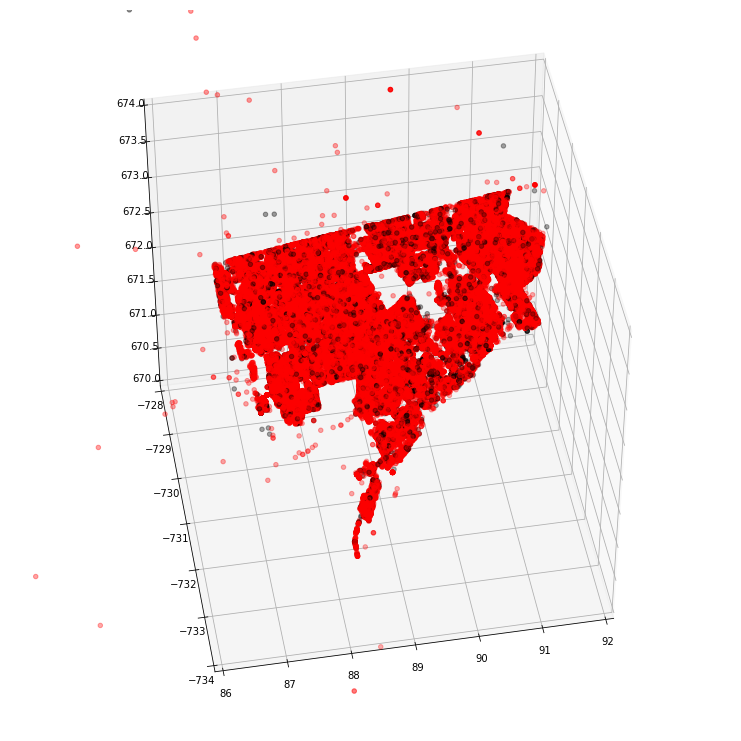

In [52]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

xyz_axis, compliance = get_spatial_data()
colors = ['black' if value == 1 else "red" for value in compliance]
fig=plt.figure(figsize=(10,10))
ax=Axes3D(fig)
ax.scatter(xyz_axis["xaxis"], xyz_axis["yaxis"], xyz_axis["zaxis"], c=colors)
ax.set_ylim3d(-734,-728)
ax.set_xlim3d(86, 92)
ax.set_zlim3d(670,674)
# setting viewing angle
ax.azim = -100
ax.elev = 45

plt.show()

Due to the imbalance of the dataset (1:12 ratio of instances that were compliant and uncompliant respectively), the function **over_sample()** is written to increase the number of compliant data points (through making copies) by a user-defined scale. The function **under_sample()** reduces the number of non-compliant data points by a user-defined fraction randomly using the pandas sample() attribute. In this notebook, the data is oversampled by a factor of 6, making the ratio much more balanced at roughly 1:2.

In [53]:
def under_sample(X_train, y_train, fraction):
	X_train["compliance"] = y_train
	zeros = X_train[X_train.compliance == 0.0]
	index = zeros.sample(frac=fraction).index
	X_train = X_train.drop(index, axis=0)
	y_train = X_train["compliance"]
	del X_train["compliance"]
	return X_train, y_train

def over_sample(X_dataset, y_dataset, scale):
	if scale == 1:
		return X_dataset
	X_dataset["compliance"] = y_dataset
	ones = X_dataset[X_dataset.compliance == 1.0]
	for i in range(scale):
		copy_ones = ones.copy()
		original = X_dataset
		X_dataset = pd.concat([original,copy_ones], axis=0)
	y_train = X_dataset["compliance"]
	del X_dataset["compliance"]
	return X_dataset, y_train

The function **fit_classifier()** will fit a Random Forest Classifier using the training data and return the classifier. This classifier is chosen for two reasons: its accuracy when it comes to categorical features and its interpretability. 

In [54]:
def fit_classifier(X_train, X_test, y_train, y_test):
    fraction = 0.0
    print("Total features: ", len(X_train.columns))
    print ("Number of Traning Data", len(X_train.index))
    #X_train, y_train = add_ones(X_train, y_train, 2)
    X_train_scaled, y_train_scaled = under_sample(X_train, y_train, fraction)
    X_train_scaled, y_train_scaled = over_sample(X_train_scaled, y_train_scaled, 6)
    print ("Ratio: {}:1".format(str(round(y_train_scaled.value_counts()[0]/y_train_scaled.value_counts()[1],3))))
    classifier = RandomForestClassifier().fit(X_train_scaled, y_train_scaled)
    print (classifier)
    return classifier
# Replace include_parcel = True with False to include parcel data for training
X_train, X_test, y_train, y_test = prepare_data(include_parcel=False)
classifier = fit_classifier(X_train, X_test, y_train, y_test)

Total features:  18
Number of Traning Data 119908
Ratio: 1.822:1
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


**Confusion matrix:**

In [55]:
def score_confusion_matrix(classifier):
    print ("Score: {}".format(classifier.score(X_test, y_test)))
    y_predicted = classifier.predict(X_test)
    print ("Confusion Matrix: ", confusion_matrix(y_test, y_predicted.round()))

score_confusion_matrix(classifier)

Score: 0.8746059544658494
Confusion Matrix:  [[33454  3636]
 [ 1376  1504]]


**ROC AUC Score:**

In [56]:
def score(classifier):
    y_predicted = classifier.predict(X_test)
    print ("ROC Score: {}".format(roc_auc_score(y_test, y_predicted)))
score(classifier)


ROC Score: 0.7120952038584824


**Feature Importance Using Gini Impurity Index:**

In [57]:
def feature_importance(classifier):
    feature_importances = classifier.feature_importances_
    sorted_indices = np.argsort(feature_importances)
    for index in sorted_indices[-10:]:
        print (X_train.columns[index], feature_importances[index])

feature_importance(classifier)
	

Jan 0.00346739683448
Responsible (Fine Waived) by Deter 0.00584676693928
Aug 0.00943207031453
Dec 0.0188283789627
fine_amount 0.0857047677856
discount_amount 0.0985579098684
Responsible by Determination 0.122246854176
nearest_neighbour 0.128086504159
Responsible by Admission 0.159051159964
Responsible by Default 0.354730916194


Responsible by Default is apparently the feature that is most important when splitting nodes in a Ranfom Forest classifier. Responsible by default means that the person ignores the ticket do not show up to the hearing. It makes sense that many of these people end up not complying at all, although some do.

However, the low values for all of the features suggest that there is no one feature that can accurately classify the data points correctly.

The function **sanity_check()** below shows that, of the 138340 tickets that were determined "Responsible by Default", only 5285 of them were compliant (since 1 stands for compliant and 0 for non-compliant, the sum of the column shows the total number of compliant data points), which is a mere 3.8%. This justifies the feature's high importance for the classifier.

In [65]:
def sanity_check():
    train_dataset = train_data_filtered.loc[:,["disposition", "compliance"]]
    share = train_dataset.groupby("disposition").agg([np.sum, np.size])
    share["share_compliant"] = share["compliance"]["sum"] / share["compliance"]["size"]
    return share
sanity_check()
    

compliance           share_compliant
                                          sum      size                
disposition                                                            
Responsible (Fine Waived) by Deter      195.0     195.0        1.000000
Responsible by Admission               3768.0   13701.0        0.275016
Responsible by Default                 5285.0  138340.0        0.038203
Responsible by Determination           2349.0    7644.0        0.307300